<a href="https://colab.research.google.com/github/IzzyBrand/robotBottleFlip/blob/main/new_flip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lots of imports

In [48]:
import numpy as np
import ipywidgets
import pydot
import os
from IPython.display import display, SVG

import importlib
import sys
from urllib.request import urlretrieve

if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='master', drake_version='20201120', drake_build='nightly')

if 'google.colab' in sys.modules and os.getenv("DISPLAY") is None:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# Use pyngrok on colab.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)


import pydrake.all
from manipulation.scenarios import AddIiwa, AddWsg, AddRgbdSensors
from manipulation.utils import FindResource

from pydrake.all import (
    AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, DiagramBuilder, 
    FindResourceOrThrow, GenerateHtml, InverseDynamicsController, 
    MultibodyPlant, Parser, Simulator)

from pydrake.all import (
    DiagramBuilder,
    RenderEngineVtkParams, MakeRenderEngineVtk, DepthCameraProperties, RgbdSensor, RigidTransform, RollPitchYaw,
    ColorRenderCamera, DepthRenderCamera, CameraInfo, ClippingRange, RenderCameraCore, DepthRange
)
    
from pydrake.all import RigidTransform, RotationMatrix, SpatialVelocity

from pydrake.all import eq, MathematicalProgram, Solve

from google.colab.patches import cv2_imshow

Upload a model of the bottle from github. Uses requests to pull the raw SDF from github. Optionally we can upload the bottle manually.

In [12]:
# from google.colab import files
# print('Please upload bottle.sdf')
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

# bottle_sdf = uploaded['bottle.sdf'].decode("utf-8")

import requests
resp = requests.get("https://raw.githubusercontent.com/IzzyBrand/robotBottleFlip/main/models/bottle.sdf")
if resp.status_code == 200:
    bottle_sdf = resp.text

### Set up the Manipulation Station

In [34]:
def MakeManipulationStation(time_step=0.002):
    builder = pydrake.systems.framework.DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = pydrake.multibody.plant.AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    pydrake.multibody.parsing.Parser(plant).AddModelFromFile(
        FindResource("models/camera_box.sdf"), "camera0")
    pydrake.multibody.parsing.Parser(plant).AddModelFromString(bottle_sdf, 'sdf')
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(pydrake.systems.primitives.PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(pydrake.systems.primitives.Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = pydrake.multibody.plant.MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        pydrake.systems.controllers.InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(pydrake.systems.primitives.Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(
        pydrake.systems.primitives.PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(), adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(), "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(), plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        pydrake.systems.primitives.StateInterpolatorWithDiscreteDerivative(
            num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(),      
                    iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(), desired_state_from_position.get_input_port())

    # Export commanded torques.
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    #builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    # Wsg controller.
    wsg_controller = builder.AddSystem(pydrake.manipulation.schunk_wsg.SchunkWsgPositionController())
    wsg_controller.set_name("wsg_controller")
    builder.Connect(wsg_controller.get_generalized_force_output_port(),             
                    plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg), wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(), "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(), "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(
        pydrake.manipulation.schunk_wsg.MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg), wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(), "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(), "wsg_force_measured")

    # Cameras.
    #color_camera = ColorRenderCamera(
    #RenderCameraCore("manip_station_renderer", CameraInfo(1080, 720, np.pi/4),
    #             ClippingRange(0.1, 10.0), RigidTransform()), False)
    
    #depth_camera = DepthRenderCamera(color_camera.core(), DepthRange(0.1, 9.5))

    AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(), "contact_results")
    builder.ExportOutput(plant.get_state_output_port(), "plant_continuous_state")

    return builder, plant, scene_graph


/opt/manipulation/manipulation/scenarios.py:197: DrakeDeprecationWarning: Constructs an RgbdSensor in the same way as the above overload, but
using the ``CameraProperties`` portion of ``properties`` for color
(and label) properties, and all of ``properties`` for depth
properties.  /
(Deprecated.)

Deprecated:
    CameraProperties are being deprecated. Please use the RenderCamera
    variant. This will be removed from Drake on or after 2021-03-01.
  show_window=False))


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6002...
You can open the visualizer by visiting the following URL:
http://b87f9dfe0eeb.ngrok.io/static/
Connected to meshcat-server.


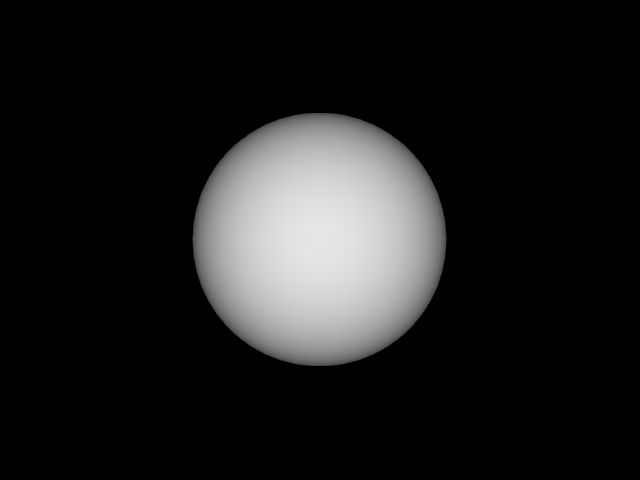

In [51]:
# set up the manipulation station
#builder = pydrake.systems.framework.DiagramBuilder()
#station = builder.AddSystem(MakeManipulationStation())

builder, plant, scene_graph = MakeManipulationStation()

# connect a meshcat visualizer
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
# not sure what this does
diagram = builder.Build()
station = builder.AddSystem(diagram)
#color_camera = ColorRenderCamera(
#    RenderCameraCore("station_renderer", CameraInfo(1080, 720, np.pi/4),
#                 ClippingRange(0.1, 10.0), RigidTransform()), False)
#X_PC = RigidTransform(RollPitchYaw([0.0, -np.pi/2.5, 0.0]), [0.7, 0.0, 0.7])
#station.RegisterRgbdSensor("single_sensor", plant.world_frame(), X_PC, depth_camera)
#station.RegisterRgbdSensor("dual_sensor", plant.world_frame(), X_PC, color_camera, depth_camera)

depth_camera = DepthRenderCamera(color_camera.core(), DepthRange(0.1, 9.5))
# get the context
context = diagram.CreateDefaultContext()
# create a simulator
simulator = Simulator(diagram)

# NOTE(izzy): i couldn't create the plant_context in the same way as the diagram
# context if I wanted to be able to set the pose of the bottle... Not at all
# sure why.

# NOTE(izzy): these initial conditions were found using the optimization
# procedure a few cells below. not sure why they aren't really working...
plant_context = station.GetMyContextFromRoot(simulator.get_mutable_context())

# Note(chris I believe this is how we access the rbg / depth images)
#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
color_image = station.GetOutputPort("camera0_rgb_image").Eval(plant_context)
point_cloud = station.GetOutputPort("camera0_point_cloud").Eval(plant_context)
color_image_np = color_image.data
cv2_imshow(color_image_np)
#plant.get_state_output_port(camera)
# position the bottle in front of the robot
plant.SetFreeBodyPose(plant_context,
                      plant.GetBodyByName('bottle_base_link'),
                      RigidTransform(RotationMatrix(), [0.5,0,0.5]))
plant.SetFreeBodySpatialVelocity(plant.GetBodyByName('bottle_base_link'),
                                 SpatialVelocity(w=[0, -1.56015115, 0], v=[0.24830577, 0., 9.52986019]),
                                 plant_context)

# no idea what this does
diagram.Publish(context)
# record an animation of the simulation advancing
meshcat.start_recording()
simulator.AdvanceTo(5.0)
meshcat.publish_recording()


In [7]:
from pydrake.all import eq, MathematicalProgram, Solve, Variable
from pydrake.all import LinearSystem, DirectTranscription
import math
import matplotlib.pyplot as plt

prog = MathematicalProgram()

dt = 0.01;
g = 9.81
N = 50
vx0 = 10
vy0 = 10
h = 3

A = np.eye(12)
A[0, 3] = 1
A[1, 4] = 1
A[2, 5] = 1
A[6, 9] = 1
A[7, 10] = 1
A[8, 11] = 1
B = dt*np.array([[0, 0, 0, 0, 0, -g, 0, 0, 0, 0, 0, 0]]).T
C = np.eye(12)
D = np.zeros((12,1))

sys = LinearSystem(A, B, C, D, dt)

prog = DirectTranscription(sys, sys.CreateDefaultContext(), N)
#prog.AddBoundingBoxConstraint(x0, x0, prog.initial_state())
#prog.AddBoundingBoxConstraint(xf, xf, prog.final_state())
#prog.AddConstraintToAllKnotPoints(prog.input()[0] == 1)
#prog.AddConstraintToAllKnotPoints(prog.input()[0] == 1)

initial_state_l = (0., 0., h, -vx0, 0, 0, 0., 0., 0, -vx0, -vy0, 0.)
initial_state_u = (0., 5., 0., vx0, 0, 100, 0., 0., 0, vx0, vy0, 0.)

prog.AddBoundingBoxConstraint(initial_state_l, initial_state_u, prog.initial_state())

final_state_l = (0., -5., 0., -vx0, -vy0, -100, 0., 0., -math.pi, 0., 0., 0.)
final_state_u = (0., 5., 0., vx0, vy0, 0, 0., 0., math.pi, 0., 0., 0.)

prog.AddBoundingBoxConstraint(final_state_l, final_state_u, prog.final_state())

#prog.AddConstraint(state[timesteps, :] == xf)
# Do timestepping. Easy to do fixed timesteps with symplectic Euler, but timesteps can be decision variables as well. 
#for t in range(timesteps + 1):
#	prog.AddConstraint(x[t+1,:] = dynamics(x[t,:]) * h)

result = Solve(prog)
x_sol = prog.ReconstructStateTrajectory(result)
assert(result.is_success()), "Optimization failed"


plt.figure()
x_values = x_sol.vector_values(x_sol.get_segment_times())

plt.plot(x_values[0,:1], x_values[1,:1])
plt.xlabel('q')
plt.ylabel('qdot')

AssertionError: ignored

In [10]:
T = 100 # number of timesteps
d = 12 # state dimension

def dynamics(x):
    dx = np.zeros_like(x)
    dx[0:3] = x[3:6] # velocity
    dx[5] = -9.81    # acceleration
    dx[6:9] = x[9:] # angular velocity
    return dx

prog = MathematicalProgram()
# create decision variables for the state and the timestep
state = prog.NewContinuousVariables(T + 1, d, 'state')
dt = prog.NewContinuousVariables(1, 'dt')

# bound the starting and ending positions
prog.AddLinearConstraint(eq(state[0,:3], np.array([0.5,0,0.5]))) # constrain initial position
prog.AddLinearConstraint(eq(state[-1,:3], np.array([1,0,0]))) # constrain final position
prog.AddLinearConstraint(eq(state[0, 6:9], np.zeros(3))) # constrain initial orientation
prog.AddLinearConstraint(eq(state[-1, 6:9], np.array([0,-np.pi, 0]))) # constrain final orientation
# force it to be rotating backwards
prog.AddBoundingBoxConstraint(np.array([0,-10,0]), np.array([0,-1,0]), state[0,9:]) # constrain intial rotational velocity

# Bound the timestep
prog.AddBoundingBoxConstraint(0.02, 0.05, dt[0])
# Do timestepping. Easy to do fixed timesteps with symplectic Euler
for t in range(T):
	prog.AddConstraint(eq(state[t+1], state[t] + dt[0]*dynamics(state[t])))
 
result = Solve(prog)
assert(result.is_success()), "Optimization failed"
print(result.GetSolution(state)[0])
print(result.GetSolution(state)[-1])
print(result.GetSolution(dt))

[ 0.5         0.          0.5         0.24830577  0.          9.52986019
  0.          0.          0.          0.         -1.56015115  0.        ]
[  1.           0.           0.           0.24830577   0.
 -10.22401044   0.          -3.14159265   0.           0.
  -1.56015115   0.        ]
[0.02013646]


# Junk

Ok, I know that the manipulation station is supposed to wrap some functionality and give us a controller, but I find it very confusing because it hides what little documented functionality drake has... so here's an attempt to not use it

In [ ]:
# top level simulation environment
builder = pydrake.systems.framework.DiagramBuilder()
# the plant is the dynamics model. The scene graph is a tree storing relations
# between objects
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-2)
# the parser allows us to add models to the plant and scene graph
parser = Parser(plant, scene_graph)
# so let's add the bottle and the robot arm
iwaa_file_path = pydrake.common.FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf")
parser.AddModelFromFile(iwaa_file_path)
parser.AddModelFromString(bottle_sdf, "sdf") # need to specify filetype
# then we need to attach the base of the robot to the ground
# plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
# and for some reason when we're done we have to call
plant.Finalize()
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)